In [1]:
import datetime
import calendar
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, fbeta_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.externals import joblib

%matplotlib inline
mpl.style.use('tableau-colorblind10')

# Analytics

In [2]:
data = pd.read_csv('KaggleV2-May-2016.csv')

In [3]:
data['ScheduledDay'] = data['ScheduledDay'].astype('datetime64[ns]')
data['AppointmentDay'] = data['AppointmentDay'].astype('datetime64[ns]')

In [4]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [6]:
len(data)

110527

In [7]:
show = data[data['No-show'] == 'No']
len(show)

88208

In [8]:
no_show = data[data['No-show'] == 'Yes']
len(no_show)

22319

In [9]:
data.dtypes

PatientId                float64
AppointmentID              int64
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                int64
Hipertension               int64
Diabetes                   int64
Alcoholism                 int64
Handcap                    int64
SMS_received               int64
No-show                   object
dtype: object

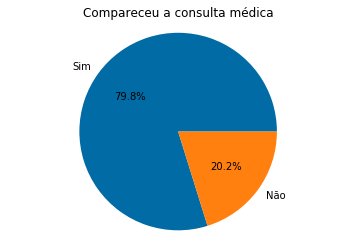

In [10]:
labels = 'Sim', 'Não'
sizes = [len(data[data['No-show'] == 'No']), len(data[data['No-show'] == 'Yes'])]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Compareceu a consulta médica')

plt.show()

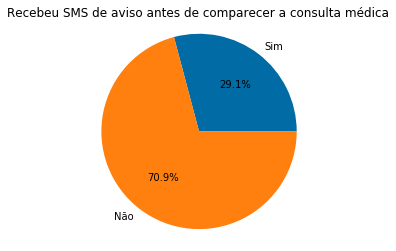

In [11]:
labels = 'Sim', 'Não'
size_1 = len(data[(data['No-show'] == 'No') & (data['SMS_received'] == 1)])
size_2 = len(data[(data['No-show'] == 'No') & (data['SMS_received'] == 0)])
sizes = [size_1, size_2]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Recebeu SMS de aviso antes de comparecer a consulta médica')

plt.show()

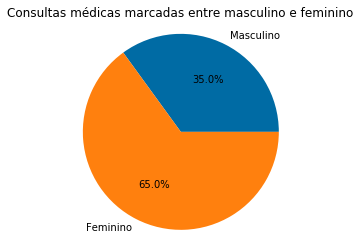

In [12]:
labels = 'Masculino', 'Feminino'
sizes = [len(data[data['Gender'] == 'M']), len(data[data['Gender'] == 'F'])]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Consultas médicas marcadas entre masculino e feminino')

plt.show()

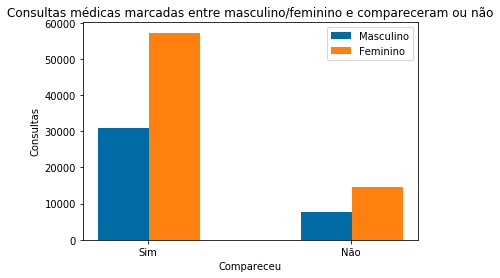

In [13]:
m1 = len(data[(data['No-show'] == 'No') & (data['Gender'] == 'M')])
m2 = len(data[(data['No-show'] == 'Yes') & (data['Gender'] == 'M')])
f1 = len(data[(data['No-show'] == 'No') & (data['Gender'] == 'F')])
f2 = len(data[(data['No-show'] == 'Yes') & (data['Gender'] == 'F')])

sizes = [[m1, m2], [f1, f2]]

X = np.arange(2)
plt.bar(X + 0.00, sizes[0], width = 0.25, label='Masculino')
plt.bar(X + 0.25, sizes[1], width = 0.25, label='Feminino')
plt.title('Consultas médicas marcadas entre masculino/feminino e compareceram ou não')
plt.legend()
plt.xticks(0.119 + np.arange(2), ('Sim', 'Não'))

plt.xlabel('Compareceu')
plt.ylabel('Consultas')

plt.show()

# Machine Learning

In [14]:
data = data.rename(columns={'PatientId': 'Patient_ID', 'AppointmentID': 'Appointment_ID',
                            'ScheduledDay': 'Scheduled_Day', 'AppointmentDay': 'Appointment_Day',
                            'SMS_received': 'SMS_Received', 'No-show': 'Show'})

In [15]:
data['Difference_Date_Medical_Consultation'] = data.apply(lambda d: str(abs((d['Scheduled_Day'] - d['Appointment_Day']).days) // 5), axis=1)

In [16]:
data['Scheduled_Day'] = data['Scheduled_Day'].apply(lambda d: list(calendar.day_name)[d.weekday()])

In [17]:
data['Appointment_Day'] = data['Appointment_Day'].apply(lambda d: list(calendar.day_name)[d.weekday()])

In [18]:
data['Gender'] = data['Gender'].apply(lambda d: 1 if d == 'M' else 0)

In [19]:
data['Age'] = data['Age'].apply(lambda d: str(d // 5))

In [20]:
data['Show'] = data['Show'].apply(lambda d: True if d == 'No' else False)

In [21]:
data = data.drop('Patient_ID', axis=1)
data = data.drop('Appointment_ID', axis=1)

In [22]:
data.dtypes

Gender                                   int64
Scheduled_Day                           object
Appointment_Day                         object
Age                                     object
Neighbourhood                           object
Scholarship                              int64
Hipertension                             int64
Diabetes                                 int64
Alcoholism                               int64
Handcap                                  int64
SMS_Received                             int64
Show                                      bool
Difference_Date_Medical_Consultation    object
dtype: object

In [23]:
data.head()

,Gender,Scheduled_Day,Appointment_Day,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_Received,Show,Difference_Date_Medical_Consultation
0,0,Friday,Friday,12,JARDIM DA PENHA,0,1,0,0,0,0,True,0
1,1,Friday,Friday,11,JARDIM DA PENHA,0,0,0,0,0,0,True,0
2,0,Friday,Friday,12,MATA DA PRAIA,0,0,0,0,0,0,True,0
3,0,Friday,Friday,1,PONTAL DE CAMBURI,0,0,0,0,0,0,True,0
4,0,Friday,Friday,11,JARDIM DA PENHA,0,1,1,0,0,0,True,0


In [24]:
data = pd.get_dummies(data)

In [25]:
data.describe()

,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_Received,Scheduled_Day_Friday,Scheduled_Day_Monday,Scheduled_Day_Saturday,...,Difference_Date_Medical_Consultation_31,Difference_Date_Medical_Consultation_32,Difference_Date_Medical_Consultation_33,Difference_Date_Medical_Consultation_35,Difference_Date_Medical_Consultation_4,Difference_Date_Medical_Consultation_5,Difference_Date_Medical_Consultation_6,Difference_Date_Medical_Consultation_7,Difference_Date_Medical_Consultation_8,Difference_Date_Medical_Consultation_9
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,...,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.171135,0.208863,0.000217,...,0.000090,0.000100,0.000072,0.000235,0.051254,0.046830,0.031069,0.020031,0.012884,0.006333
std,0.476979,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.376628,0.406498,0.014734,...,0.009511,0.009976,0.008507,0.015336,0.220517,0.211276,0.173506,0.140108,0.112773,0.079330
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
ml_data_not_show = data[data['Show'] == False]
len(ml_data_not_show)

22319

In [27]:
ml_data_show = data[data['Show'] == True].head(len(ml_data_not_show))
len(ml_data_show)

22319

In [28]:
ml_data = ml_data_not_show.append(ml_data_show)
len(ml_data)

44638

In [29]:
ml_data.head()

,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_Received,Show,Scheduled_Day_Friday,Scheduled_Day_Monday,...,Difference_Date_Medical_Consultation_31,Difference_Date_Medical_Consultation_32,Difference_Date_Medical_Consultation_33,Difference_Date_Medical_Consultation_35,Difference_Date_Medical_Consultation_4,Difference_Date_Medical_Consultation_5,Difference_Date_Medical_Consultation_6,Difference_Date_Medical_Consultation_7,Difference_Date_Medical_Consultation_8,Difference_Date_Medical_Consultation_9
6,0,0,0,0,0,0,0,False,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,False,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1,0,0,0,0,0,1,False,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,1,0,0,0,0,0,False,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,False,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
y = ml_data.Show
X = ml_data.drop('Show', axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=8)

In [32]:
len(X_train)

35710

In [33]:
len(X_test)

8928

In [34]:
gaussian_nb = None

if Path('models/GaussianNB.pkl').is_file():
    gaussian_nb = joblib.load('models/GaussianNB.pkl')
else:
    gaussian_nb = GaussianNB()
    gaussian_nb.fit(X_train, y_train)
    joblib.dump(gaussian_nb, 'models/GaussianNB.pkl')

pred = gaussian_nb.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(gaussian_nb.get_params())

0.5267697132616488
0.5666402744787543
0.5277471551943385
{'priors': None}


In [35]:
sgd_classifier = None

if Path('models/SGDClassifier.pkl').is_file():
    sgd_classifier = joblib.load('models/SGDClassifier.pkl')
else:
    sgd_classifier = SGDClassifier(random_state=8)
    sgd_classifier.fit(X_train, y_train)
    joblib.dump(sgd_classifier, 'models/SGDClassifier.pkl')

pred = sgd_classifier.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(sgd_classifier.get_params())

0.6658826164874552
0.6634805821062603
0.6659409080936425
{'alpha': 0.0001, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': None, 'n_iter': None, 'n_jobs': 1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 8, 'shuffle': True, 'tol': None, 'verbose': 0, 'warm_start': False}


In [36]:
decision_tree_classifier = None

if Path('models/DecisionTreeClassifier.pkl').is_file():
    decision_tree_classifier = joblib.load('models/DecisionTreeClassifier.pkl')
else:
    decision_tree_classifier = DecisionTreeClassifier(random_state=8)
    decision_tree_classifier.fit(X_train, y_train)
    joblib.dump(decision_tree_classifier, 'models/DecisionTreeClassifier.pkl')

pred = decision_tree_classifier.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(decision_tree_classifier.get_params())

0.6805555555555556
0.6806783988328623
0.6805328757743939
{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 8, 'splitter': 'best'}


In [37]:
random_forest_classifier = None

if Path('models/RandomForestClassifier.pkl').is_file():
    random_forest_classifier = joblib.load('models/RandomForestClassifier.pkl')
else:
    random_forest_classifier = RandomForestClassifier(random_state=8)
    random_forest_classifier.fit(X_train, y_train)
    joblib.dump(random_forest_classifier, 'models/RandomForestClassifier.pkl')

pred = random_forest_classifier.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(random_forest_classifier.get_params())

0.6967965949820788
0.7026881192975571
0.6966768932267239
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 8, 'verbose': 0, 'warm_start': False}


In [38]:
ada_boost_classifier = None

if Path('models/AdaBoostClassifier.pkl').is_file():
    ada_boost_classifier = joblib.load('models/AdaBoostClassifier.pkl')
else:
    ada_boost_classifier = AdaBoostClassifier(random_state=8)
    ada_boost_classifier.fit(X_train, y_train)
    joblib.dump(ada_boost_classifier, 'models/AdaBoostClassifier.pkl')

pred = ada_boost_classifier.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(ada_boost_classifier.get_params())

0.6822356630824373
0.6822523423997089
0.6822162536063779
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 8}


In [39]:
gradient_boosting_classifier = None

if Path('models/GradientBoostingClassifier.pkl').is_file():
    gradient_boosting_classifier = joblib.load('models/GradientBoostingClassifier.pkl')
else:
    gradient_boosting_classifier = GradientBoostingClassifier(random_state=8)
    gradient_boosting_classifier.fit(X_train, y_train)
    joblib.dump(gradient_boosting_classifier, 'models/GradientBoostingClassifier.pkl')

pred = gradient_boosting_classifier.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(gradient_boosting_classifier.get_params())

0.6798835125448028
0.6821411653244908
0.679809141235927
{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 8, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}


In [40]:
svc = None

if Path('models/SVC.pkl').is_file():
    svc = joblib.load('models/SVC.pkl')
else:
    svc = SVC(random_state=8, max_iter=1000)
    svc.fit(X_train, y_train)
    joblib.dump(svc, 'models/SVC.pkl')

pred = svc.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(svc.get_params())

0.5300179211469535
0.5634815624460681
0.5307994160342479
{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1000, 'probability': False, 'random_state': 8, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [41]:
logistic_regression = None

if Path('models/LogisticRegression.pkl').is_file():
    logistic_regression = joblib.load('models/LogisticRegression.pkl')
else:
    logistic_regression = LogisticRegression(random_state=8)
    logistic_regression.fit(X_train, y_train)
    joblib.dump(logistic_regression, 'models/LogisticRegression.pkl')

pred = logistic_regression.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(logistic_regression.get_params())

0.6859318996415771
0.6847119579734663
0.6859423674058308
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 8, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [42]:
refined_decision_tree_classifier = None

if Path('models/Refined_DecisionTreeClassifier.pkl').is_file():
    refined_decision_tree_classifier = joblib.load('models/Refined_DecisionTreeClassifier.pkl')
else:
    refined_decision_tree_classifier = DecisionTreeClassifier()
    parameters = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'min_weight_fraction_leaf': [0, 0.25, 0.5], 'min_impurity_decrease': [0, 0.25, 0.5], 'presort': [True, False], 'random_state': [8]}
    grid_search_cv = GridSearchCV(refined_decision_tree_classifier, parameters)
    grid_search_cv.fit(X_train, y_train)
    refined_decision_tree_classifier = grid_search_cv.best_estimator_
    joblib.dump(refined_decision_tree_classifier, 'models/Refined_DecisionTreeClassifier.pkl')

pred = refined_decision_tree_classifier.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(refined_decision_tree_classifier.get_params())

0.6851478494623656
0.685783818532464
0.6851154071049435
{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'presort': True, 'random_state': 8, 'splitter': 'random'}


In [43]:
refined_random_forest_classifier = None

if Path('models/Refined_RandomForestClassifier.pkl').is_file():
    refined_random_forest_classifier = joblib.load('models/Refined_RandomForestClassifier.pkl')
else:
    refined_random_forest_classifier = RandomForestClassifier()
    parameters = {'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3], 'oob_score': [True, False], 'random_state': [8]}
    grid_search_cv = GridSearchCV(refined_random_forest_classifier, parameters)
    grid_search_cv.fit(X_train, y_train)
    refined_random_forest_classifier = grid_search_cv.best_estimator_
    joblib.dump(refined_random_forest_classifier, 'models/Refined_RandomForestClassifier.pkl')

pred = refined_random_forest_classifier.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(refined_random_forest_classifier.get_params())

0.709005376344086
0.7118136750537835
0.7089482132860037
{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': True, 'random_state': 8, 'verbose': 0, 'warm_start': False}


In [44]:
refined_ada_boost_classifier = None

if Path('models/Refined_AdaBoostClassifier.pkl').is_file():
    refined_ada_boost_classifier = joblib.load('models/Refined_AdaBoostClassifier.pkl')
else:
    refined_ada_boost_classifier = AdaBoostClassifier()
    parameters = {'n_estimators': [50, 100, 150], 'learning_rate': [1.0, 2.0, 3.0], 'algorithm': ['SAMME', 'SAMME.R'], 'random_state': [8]}
    grid_search_cv = GridSearchCV(refined_ada_boost_classifier, parameters)
    grid_search_cv.fit(X_train, y_train)
    refined_ada_boost_classifier = grid_search_cv.best_estimator_
    joblib.dump(refined_ada_boost_classifier, 'models/Refined_AdaBoostClassifier.pkl')

pred = refined_ada_boost_classifier.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(refined_ada_boost_classifier.get_params())

0.683915770609319
0.6828321584723832
0.6839232172955994
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 100, 'random_state': 8}


In [45]:
refined_logistic_regression = None

if Path('models/Refined_LogisticRegression.pkl').is_file():
    refined_logistic_regression = joblib.load('models/Refined_LogisticRegression.pkl')
else:
    refined_logistic_regression = LogisticRegression()
    parameters = {'C': [0.1, 1, 10], 'fit_intercept': [True, False], 'intercept_scaling': [1, 10, 100], 'random_state': [8], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    grid_search_cv = GridSearchCV(refined_logistic_regression, parameters)
    grid_search_cv.fit(X_train, y_train)
    refined_logistic_regression = grid_search_cv.best_estimator_
    joblib.dump(refined_logistic_regression, 'models/Refined_LogisticRegression.pkl')

pred = refined_logistic_regression.predict(X_test)

print(accuracy_score(y_test, pred, normalize=True))
print(fbeta_score(y_test, pred, beta=0.5))
print(roc_auc_score(y_test, pred))
print(refined_logistic_regression.get_params())

0.6857078853046595
0.6844681797952826
0.685718853771499
{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 8, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


# Check Machine Learning Algorithm With All Data 

In [46]:
full_y = data.Show
full_X = data.drop('Show', axis=1)

In [47]:
len(data)

110527

In [48]:
refined_decision_tree_classifier = joblib.load('models/Refined_DecisionTreeClassifier.pkl')

pred = refined_decision_tree_classifier.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.6238385190948817
0.8256019691311274
0.6982471317403187


In [49]:
refined_random_forest_classifier = joblib.load('models/Refined_RandomForestClassifier.pkl')

pred = refined_random_forest_classifier.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.6288508690184299
0.8273384769952085
0.6972039321527738


In [50]:
refined_ada_boost_classifier = joblib.load('models/Refined_AdaBoostClassifier.pkl')

pred = refined_ada_boost_classifier.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.5798764102888887
0.7824173999667939
0.6156828296439422


In [51]:
refined_logistic_regression = joblib.load('models/Refined_LogisticRegression.pkl')

pred = refined_logistic_regression.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.5816497326445123
0.7833710767038586
0.6159069370669169


In [52]:
random_forest_classifier = joblib.load('models/RandomForestClassifier.pkl')

pred = random_forest_classifier.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.6462131424900703
0.8509508091566329
0.7476073791531948


In [53]:
ada_boost_classifier = joblib.load('models/AdaBoostClassifier.pkl')

pred = ada_boost_classifier.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.5784468953287432
0.7821840410351344
0.6177491403283071


In [54]:
gradient_boosting_classifier = joblib.load('models/GradientBoostingClassifier.pkl')

pred = gradient_boosting_classifier.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.6010929456150986
0.7995772044861895
0.6427473710010319


In [55]:
gaussian_nb = joblib.load('models/GaussianNB.pkl')

pred = gaussian_nb.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.7572448361033955
0.8234940196893954
0.5099336732015657


In [56]:
decision_tree_classifier = joblib.load('models/DecisionTreeClassifier.pkl')

pred = decision_tree_classifier.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.6638016050376832
0.8621981545710359
0.761722581021749


In [57]:
svc = joblib.load('models/SVC.pkl')

pred = svc.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.7297402444651533
0.8189212877848561
0.5248142552780048


In [58]:
logistic_regression = joblib.load('models/LogisticRegression.pkl')

pred = logistic_regression.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.5815321143250065
0.7833019444161663
0.615866715640218


In [59]:
sgd_classifier = joblib.load('models/SGDClassifier.pkl')

pred = sgd_classifier.predict(full_X)

print(accuracy_score(full_y, pred, normalize=True))
print(fbeta_score(full_y, pred, beta=0.5))
print(roc_auc_score(full_y, pred))

0.5724755037230722
0.7737338385809424
0.5947136611314753


# Save Decision Tree Classifier in PDF

In [60]:
refined_decision_tree_classifier_image = tree.export_graphviz(refined_decision_tree_classifier, out_file=None) 
graph = graphviz.Source(refined_decision_tree_classifier_image, format='pdf') 
graph.render('refined_decision_tree_classifier_image')

'refined_decision_tree_classifier_image.pdf'

# Machine Learning With All Data

In [61]:
y_full = data.Show
X_full = data.drop('Show', axis=1)

In [62]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full,
                                                                        test_size=0.2,
                                                                        random_state=8)

In [63]:
print(len(X_train_full))
print(len(X_test_full))

88421
22106


In [64]:
full_gaussian_nb = None

if Path('models/Full_GaussianNB.pkl').is_file():
    full_gaussian_nb = joblib.load('models/Full_GaussianNB.pkl')
else:
    full_gaussian_nb = GaussianNB()
    full_gaussian_nb.fit(X_train_full, y_train_full)
    joblib.dump(full_gaussian_nb, 'models/Full_GaussianNB.pkl')

pred = full_gaussian_nb.predict(X_test_full)

print(accuracy_score(y_test_full, pred, normalize=True))
print(fbeta_score(y_test_full, pred, beta=0.5))
print(roc_auc_score(y_test_full, pred))
print(gaussian_nb.get_params())

0.5931421333574595
0.7862785926447623
0.6075715861256443
{'priors': None}


In [65]:
full_sgd_classifier = None

if Path('models/Full_SGDClassifier.pkl').is_file():
    full_sgd_classifier = joblib.load('models/Full_SGDClassifier.pkl')
else:
    full_sgd_classifier = SGDClassifier(random_state=8)
    full_sgd_classifier.fit(X_train_full, y_train_full)
    joblib.dump(full_sgd_classifier, 'models/Full_SGDClassifier.pkl')

pred = full_sgd_classifier.predict(X_test_full)

print(accuracy_score(y_test_full, pred, normalize=True))
print(fbeta_score(y_test_full, pred, beta=0.5))
print(roc_auc_score(y_test_full, pred))
print(sgd_classifier.get_params())

0.7966163032660816
0.8303940245581606
0.5
{'alpha': 0.0001, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': None, 'n_iter': None, 'n_jobs': 1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 8, 'shuffle': True, 'tol': None, 'verbose': 0, 'warm_start': False}


In [66]:
full_decision_tree_classifier = None

if Path('models/Full_DecisionTreeClassifier.pkl').is_file():
    full_decision_tree_classifier = joblib.load('models/Full_DecisionTreeClassifier.pkl')
else:
    full_decision_tree_classifier = DecisionTreeClassifier(random_state=8)
    full_decision_tree_classifier.fit(X_train_full, y_train_full)
    joblib.dump(full_decision_tree_classifier, 'models/Full_DecisionTreeClassifier.pkl')

pred = full_decision_tree_classifier.predict(X_test_full)

print(accuracy_score(y_test_full, pred, normalize=True))
print(fbeta_score(y_test_full, pred, beta=0.5))
print(roc_auc_score(y_test_full, pred))
print(decision_tree_classifier.get_params())

0.7353207274043246
0.832038725655747
0.5835169908111899
{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 8, 'splitter': 'best'}


In [67]:
full_random_forest_classifier = None

if Path('models/Full_RandomForestClassifier.pkl').is_file():
    full_random_forest_classifier = joblib.load('models/Full_RandomForestClassifier.pkl')
else:
    full_random_forest_classifier = RandomForestClassifier(random_state=8)
    full_random_forest_classifier.fit(X_train_full, y_train_full)
    joblib.dump(full_random_forest_classifier, 'models/Full_RandomForestClassifier.pkl')

pred = full_random_forest_classifier.predict(X_test_full)

print(accuracy_score(y_test_full, pred, normalize=True))
print(fbeta_score(y_test_full, pred, beta=0.5))
print(roc_auc_score(y_test_full, pred))
print(random_forest_classifier.get_params())

0.7654935311680087
0.8377526993487622
0.5736347761200062
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 8, 'verbose': 0, 'warm_start': False}


In [68]:
full_ada_boost_classifier = None

if Path('models/Full_AdaBoostClassifier.pkl').is_file():
    full_ada_boost_classifier = joblib.load('models/Full_AdaBoostClassifier.pkl')
else:
    full_ada_boost_classifier = AdaBoostClassifier(random_state=8)
    full_ada_boost_classifier.fit(X_train_full, y_train_full)
    joblib.dump(full_ada_boost_classifier, 'models/Full_AdaBoostClassifier.pkl')

pred = full_ada_boost_classifier.predict(X_test_full)

print(accuracy_score(y_test_full, pred, normalize=True))
print(fbeta_score(y_test_full, pred, beta=0.5))
print(roc_auc_score(y_test_full, pred))
print(ada_boost_classifier.get_params())

0.7962996471546187
0.8303451790061712
0.5001325173136422
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 8}


In [69]:
full_gradient_boosting_classifier = None

if Path('models/Full_GradientBoostingClassifier.pkl').is_file():
    full_gradient_boosting_classifier = joblib.load('models/Full_GradientBoostingClassifier.pkl')
else:
    full_gradient_boosting_classifier = GradientBoostingClassifier(random_state=8)
    full_gradient_boosting_classifier.fit(X_train_full, y_train_full)
    joblib.dump(full_gradient_boosting_classifier, 'models/Full_GradientBoostingClassifier.pkl')

pred = full_gradient_boosting_classifier.predict(X_test_full)

print(accuracy_score(y_test_full, pred, normalize=True))
print(fbeta_score(y_test_full, pred, beta=0.5))
print(roc_auc_score(y_test_full, pred))
print(gradient_boosting_classifier.get_params())

0.7972496154890075
0.8309727494192963
0.5023022925545781
{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 8, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}


In [70]:
full_svc = None

if Path('models/Full_SVC.pkl').is_file():
    full_svc = joblib.load('models/Full_SVC.pkl')
else:
    full_svc = SVC(random_state=8, max_iter=1000)
    full_svc.fit(X_train_full, y_train_full)
    joblib.dump(full_svc, 'models/Full_SVC.pkl')

pred = full_svc.predict(X_test_full)

print(accuracy_score(y_test_full, pred, normalize=True))
print(fbeta_score(y_test_full, pred, beta=0.5))
print(roc_auc_score(y_test_full, pred))
print(svc.get_params())

0.7026599113362888
0.8071263862962557
0.509931573980329
{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1000, 'probability': False, 'random_state': 8, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [71]:
full_logistic_regression = None

if Path('models/Full_LogisticRegression.pkl').is_file():
    full_logistic_regression = joblib.load('models/Full_LogisticRegression.pkl')
else:
    full_logistic_regression = LogisticRegression(random_state=8)
    full_logistic_regression.fit(X_train_full, y_train_full)
    joblib.dump(full_logistic_regression, 'models/Full_LogisticRegression.pkl')

pred = full_logistic_regression.predict(X_test_full)

print(accuracy_score(y_test_full, pred, normalize=True))
print(fbeta_score(y_test_full, pred, beta=0.5))
print(roc_auc_score(y_test_full, pred))
print(logistic_regression.get_params())

0.7961639373925631
0.830421726567074
0.5007098744849355
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 8, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
